In [1]:
import pandas as pd
import numpy as np
import os
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
clients = pd.read_csv('.\data\clients.csv')
products = pd.read_csv('.\data\products.csv')
stocks = pd.read_csv('.\data\stocks.csv')
stores = pd.read_csv('.\data\stores.csv')
transactions = pd.read_csv('./data/transactions.csv')

In [3]:
print('clients: ', clients.columns)
print('products: ', products.columns)
print('stocks: ',stocks.columns)
print('stores: ',stores.columns)
print('transactions: ', transactions.columns)

clients:  Index(['ClientID', 'ClientSegment', 'ClientCountry', 'ClientOptINEmail',
       'ClientOptINPhone', 'ClientGender', 'Age'],
      dtype='object')
products:  Index(['ProductID', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe'], dtype='object')
stocks:  Index(['StoreCountry', 'ProductID', 'Quantity'], dtype='object')
stores:  Index(['StoreID', 'StoreCountry'], dtype='object')
transactions:  Index(['ClientID', 'ProductID', 'SaleTransactionDate', 'StoreID', 'Quantity',
       'SalesNetAmountEuro'],
      dtype='object')


In [4]:
transactions.head()

,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99


In [ ]:
transactions['SaleTransactionDate'] = transactions['SaleTransactionDate'].astype(str).str[:10]
transactions['SaleTransactionDate'] = pd.to_datetime(transactions['SaleTransactionDate'])

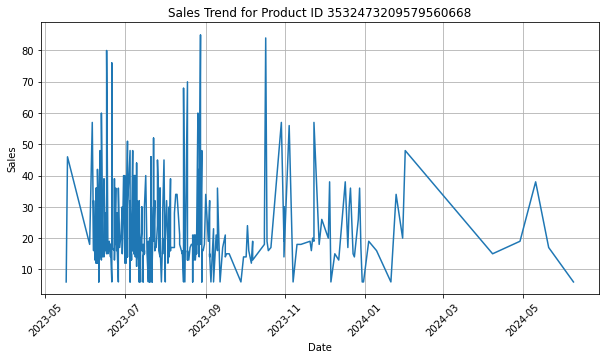

In [ ]:
product_ID = 3532473209579560668
prods = transactions[transactions['ProductID']==product_ID]
prods = prods.sort_values(by='SaleTransactionDate')

plt.figure(figsize=(10, 5))
plt.plot(prods['SaleTransactionDate'], prods['SalesNetAmountEuro'], linestyle='-')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Sales Trend for Product ID {product_ID}')
plt.xticks(rotation=45)
plt.grid()

# Show plot
plt.show()

## Transaction Clustering (Same Client, Same date, different products)

In [142]:
grouped_df = transactions.groupby(['ClientID', 'SaleTransactionDate']).agg(
    total_quantity=('Quantity', 'sum'), 
    total_amount_spent=('SalesNetAmountEuro', 'sum'),
    transaction_count=('ProductID', 'count')
).reset_index()

# Display the grouped DataFrame
# grouped_df.head(25)

### Product life-cycle

In [152]:
# Step 1: Group by 'ClientID' and 'ProductID' and count the unique 'SaleTransactionDate'
count_dates = transactions.groupby(['ClientID', 'ProductID'])['SaleTransactionDate'].nunique().reset_index()

# Step 2: Filter for rows where 'SaleTransactionDate' count is greater than 1
multiple_dates = count_dates[count_dates['SaleTransactionDate'] > 1]

# Step 3: Merge back to get the original rows
result = transactions.merge(multiple_dates[['ClientID', 'ProductID']], on=['ClientID', 'ProductID'], how='inner')

# Display the result (rows where the same product was bought on different dates)
result.head()


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99
1,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99
2,3183538914940113691,4264340979150525540,2024-07-20 00:00:00+00:00,9099531021898466037,4,50.97
3,970324337306047537,8984524553119131282,2023-04-21 00:00:00+00:00,1462011113949538177,1,5.99
4,4516550870786564525,6488384657788009650,2024-06-04 00:00:00+00:00,3325697448103923280,1,5.99


In [ ]:
# Step 1: Count the number of unique products per ClientID per SaleTransactionDate
grouped_df = transactions.groupby(['ClientID', 'SaleTransactionDate'])['ProductID'].nunique().reset_index()

# Step 2: Filter to find cases where the same ClientID bought more than 1 ProductID on the same date
multiple_products_df = grouped_df[grouped_df['ProductID'] > 1]

# Step 3: Merge back with the original DataFrame to get full transaction details
result_df = transactions.merge(multiple_products_df[['ClientID', 'SaleTransactionDate']], on=['ClientID', 'SaleTransactionDate'], how='inner')

# Step 4: Sort by ClientID, SaleTransactionDate, and ProductID
result_df = result_df.sort_values(by=['ClientID', 'SaleTransactionDate', 'ProductID']).reset_index(drop=True)

# Display the result
result_df.head(25)

,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,487831788379074,2820126687947308401,2023-06-15 00:00:00+00:00,5202366601222773915,2,9.99
1,487831788379074,5814271529755388521,2023-06-15 00:00:00+00:00,5202366601222773915,2,8.99
2,487831788379074,596160146527302814,2023-11-15 00:00:00+00:00,5202366601222773915,1,3.99
3,487831788379074,3245181039283805384,2023-11-15 00:00:00+00:00,5202366601222773915,2,4.99
4,487831788379074,845645642533440388,2023-11-16 00:00:00+00:00,5202366601222773915,3,15.98
5,487831788379074,4772494314287191459,2023-11-16 00:00:00+00:00,5202366601222773915,4,14.97
6,624987180068091,4088240615781117851,2024-02-13 00:00:00+00:00,3325697448103923280,1,16.99
7,624987180068091,6836501382109623577,2024-02-13 00:00:00+00:00,3325697448103923280,2,20.99
8,633157752238300,7351594082589762847,2024-12-19 00:00:00+00:00,7242889412692100661,2,25.99
9,633157752238300,7824611703074545864,2024-12-19 00:00:00+00:00,7242889412692100661,1,76.99


## Client Spending

In [112]:
client_summary = transactions.groupby('ClientID').agg(
    TransactionCount=('ClientID', 'size'),  # Counts number of transactions for each ClientID
    TotalAmountSpent=('SalesNetAmountEuro', 'sum')      # Sums the 'Amount' column for each ClientID
).reset_index()

In [113]:
client_summary_sorted = client_summary.sort_values(by='TotalAmountSpent', ascending=False)
print(client_summary_sorted)

                   ClientID  TransactionCount  TotalAmountSpent
25827    784139077380372687             44460         557936.09
164153  4948726587055327420               319         504978.77
237327  7170141520984547731               971         339760.44
37204   1132261303486551948                 9         152320.92
115168  3468904384835684271                19         121431.77
...                     ...               ...               ...
130387  3928084724934230417                 1              0.01
138320  4170568209692584807                 1              0.01
137909  4157637604884968322                 1              0.01
113979  3433262166679570786                 1              0.01
83346   2513468324000536698                 1              0.01

[304929 rows x 3 columns]


## Product Combinations

In [26]:
chunk_transactions = transactions[:10000]
client_products = chunk_transactions.groupby('ClientID')['ProductID'].apply(list).reset_index()

In [27]:
products.head()

,ProductID,Category,FamilyLevel1,FamilyLevel2,Universe
0,43220326960179274,Football,Ball,Nike Ordem V,Women
1,622915065731236396,Football,Ball,Nike Ordem V,Men
2,2020543468978812774,Football,Shorts,Nike Dri-FIT,Women
3,600002891277549143,Football,Shorts,Nike Dri-FIT,Women
4,6150916997899913693,Football,Shorts,Nike Dri-FIT,Men


In [30]:

def combination_items(n=2, df=chunk_transactions, products_df=products):    
    product_combinations = []

    # Create combinations for each client
    for prod in df.groupby('ClientID')['ProductID'].apply(list):
        if len(prod) >= n:
            product_combinations.extend(combinations(sorted(prod), n))

    # Step 3: Create a DataFrame with the product combinations
    df_combinations = pd.DataFrame(product_combinations, columns=[f'ProductID_{i+1}' for i in range(n)])

    # Step 4: Count occurrences of each combination
    product_combination_counts = df_combinations.value_counts().reset_index(name='CombinationCount')

    # Step 5: Merge with products DataFrame to get product names for each ProductID
    for i in range(n):
        product_combination_counts = product_combination_counts.merge(
            products_df[['ProductID', 'Category']], 
            left_on=f'ProductID_{i+1}', right_on='ProductID', how='left'
        ).rename(columns={'Category': f'ProductName_{i+1}'})

    # Step 6: Sort by CombinationCount
    sorted_product_combinations = product_combination_counts.sort_values(by='CombinationCount', ascending=False)

    # Step 7: Create the combination tuple for FamilyLevel2 columns
    sorted_product_combinations['Combination'] = list(zip(sorted_product_combinations['ProductID_1'], sorted_product_combinations['ProductID_2']))

    # Step 8: Filter out relevant columns for plotting (Combination and CombinationCount)
    combination_counts = sorted_product_combinations[['Combination', 'CombinationCount']]

    return combination_counts

def plot_combinations(df):
    # Create the plot with tuples of FamilyLevel2 as x-axis
    plt.figure(figsize=(12, 6))
    
    # Create a barplot
    sns.barplot(x='Combination', y='CombinationCount', data=df, palette='Blues_d')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")

    # Set the plot labels and title
    plt.xlabel('Product Combinations (FamilyLevel2_x, FamilyLevel2_y)')
    plt.ylabel('Combination Count')
    plt.title('Most Frequent Product Combinations')
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [ ]:
# Display the result
combination_2 = combination_items(2)
combination_3 = combination_items(3)
combination_4 = combination_items(4)

In [32]:
combination_2.head()

,Combination,CombinationCount
0,"(603187737005716068, 2203331223924251032)",40
1,"(2203331223924251032, 3570677365406858878)",32
2,"(2203331223924251032, 5163377520676763238)",32
3,"(2203331223924251032, 5352761506352678096)",32
4,"(2203331223924251032, 2203331223924251032)",28


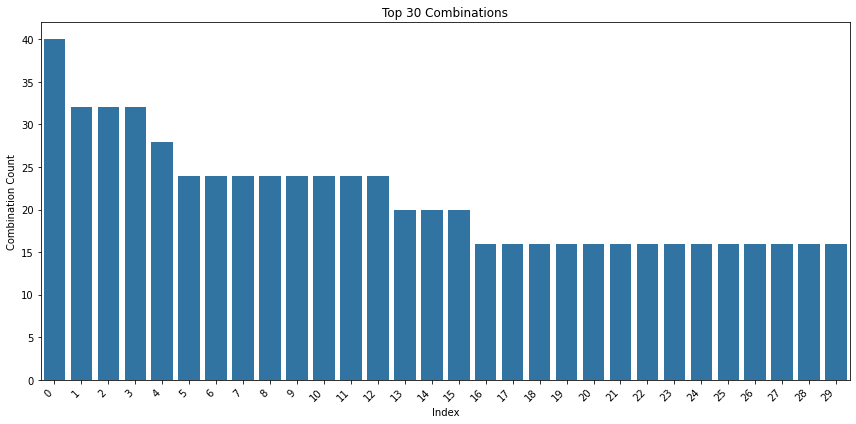

In [34]:
# Reset index to make plotting easier
plot_data = combination_2.head(30).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=plot_data.index, y=plot_data['CombinationCount'])
plt.title('Top 30 Combinations')
plt.xlabel('Index')
plt.ylabel('Combination Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Recommender

In [37]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Define rating scale (assume Quantity is an implicit rating)
reader = Reader(rating_scale=(1, transactions['Quantity'].max()))
data = Dataset.load_from_transactions(transactions[['ClientID', 'ProductID', 'Quantity']], reader)

# Train SVD model
trainset, testset = train_test_split(data, test_size=0.2)
model = SVD()
model.fit(trainset)

# Predict for a given user and product
pred = model.predict(uid=12345, iid=67890)  # Example ClientID and ProductID
print(pred.est)  # Estimated preference score

ModuleNotFoundError: No module named 'surprise'